In [53]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# Import MNE, as well as the MNE sample dataset
import mne
from mne import io
from mne.datasets import sample
from mne.viz import plot_topomap

# Import some NeuroDSP functions to use with MNE
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.rhythm import compute_lagged_coherence


# Import NeuroDSP plotting functions
from neurodsp.plts import (plot_time_series, plot_power_spectra,
                           plot_bursts, plot_lagged_coherence)




#'C:/Users/MAJDA/Desktop/Projet_4A/AXEL/droite/EEG.csv'
#'C:/Users/MAJDA/Desktop/Projet_4A/EEG-Hand-Movement-Decoding-master/MATLAB/biosig/MajdaComp/Data_Left_1_1_1.csv'

Creating RawArray with float64 data, n_channels=10, n_times=1759
    Range : 0 ... 1758 =      0.000 ...     6.867 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 30.00 Hz: -6.02, -6.02 dB



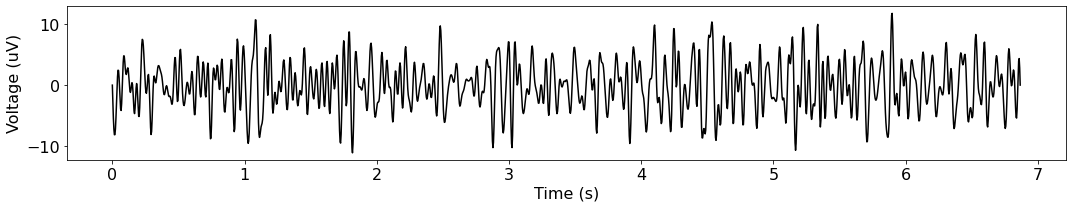

In [59]:
import pandas as pd
import numpy as np
import mne

# Replace with the path to your CSV data file
data_file = 'Data_Left_1_1_1.csv'

# Load the CSV data using pandas or numpy
data = pd.read_csv(data_file)  # or np.loadtxt(data_file, delimiter=',')

# Extract the necessary information from the data
# Replace channel_names and sampling_rate with your actual channel names and sampling rate
channel_names = ['FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'A2']
sampling_rate = 256  # Replace with your actual sampling rate

# Create the MNE Info structure
info = mne.create_info(channel_names, sfreq=sampling_rate, ch_types='eeg')

# Create the MNE Raw object
raw = mne.io.RawArray(data.T, info)

# Now you can continue with your analysis using the raw object

# Select EEG channels from the dataset
raw = raw.pick_types(meg=False, eeg=True, eog=False, exclude='bads')
raw.filter(7,30,method="iir")

# Grab the sampling rate from the data
fs = raw.info['sfreq']

# Settings for exploring an example channel of data
ch_label = 'FC3'
t_start = 0
t_stop = int(t_start + (7 * fs))

# Extract an example channel to explore
sig, times = raw.get_data(mne.pick_channels(raw.ch_names, [ch_label]),
                          start=t_start, stop=t_stop, return_times=True)
sig = np.squeeze(sig)

# Plot a segment of the extracted time series data
plot_time_series(times, sig)

In [36]:
# Calculate the power spectrum, using median Welch's & extract a frequency range of interest
freqs, powers = compute_spectrum(sig, fs, method='welch', avg_type='median')
freqs, powers = trim_spectrum(freqs, powers, [3, 30])

In [37]:
# Check where the peak power is
peak_cf = freqs[np.argmax(powers)]
print(peak_cf)

7.0


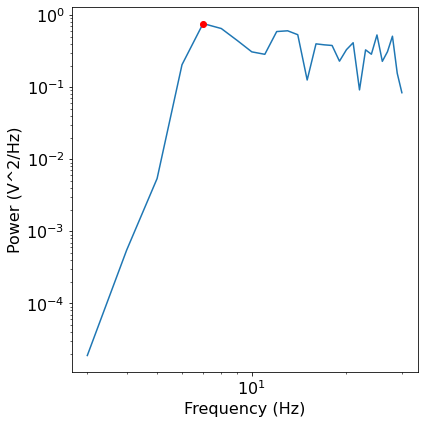

In [9]:
# Plot the power spectra, and note the peak power
plot_power_spectra(freqs, powers)
plt.plot(freqs[np.argmax(powers)], np.max(powers), '.r', ms=12)

In [10]:
# Burst settings
amp_dual_thresh = (1., 1.5)
f_range = (peak_cf-2, peak_cf+2)

In [11]:
# Detect bursts of high amplitude oscillations in the extracted signal
bursting = detect_bursts_dual_threshold(sig, fs, amp_dual_thresh, f_range)

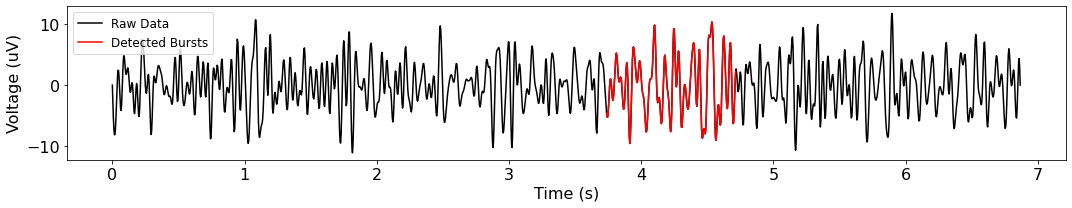

In [12]:
# Plot original signal and burst activity
plot_bursts(times, sig, bursting, labels=['Raw Data', 'Detected Bursts'])

In [13]:
# Settings for lagged coherence, as frequency range (start, stop, step)
f_range = (5, 25, 0.25)

In [14]:
# Calculate lagged coherence on our example channel data
lcs, freqs = compute_lagged_coherence(sig, fs, f_range, return_spectrum=True)

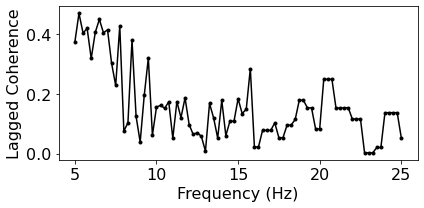

In [15]:
# Visualize lagged coherence across all frequencies
plot_lagged_coherence(freqs, lcs)

In [16]:
# Get the most rhythmic frequency and the associated lagged coherence score
max_freq = freqs[np.argmax(lcs)]
max_score = np.max(lcs)

print('The frequency with the greatest rhythmicity is {:1.1f} Hz '\
      'with a lagged coherence score of {:1.2f}.'.format(max_freq, max_score))

The frequency with the greatest rhythmicity is 5.2 Hz with a lagged coherence score of 0.47.


In [17]:
# Set a 30 second window of data to analyze
t_start =  0
t_stop = int(t_start + (60 * fs))

# Initialize output variables
max_freq = np.zeros(len(raw.ch_names))
max_score = np.zeros(len(raw.ch_names))

# Loop lagged coherence across each channel
for ind, ch_label in enumerate(raw.ch_names):

    # Extract current channel data
    cur_sig = np.squeeze(raw.get_data(mne.pick_channels(raw.ch_names, [ch_label]),
                                      start=t_start, stop=t_stop))

    # Calculate lagged coherence on current channel data
    cur_lcs, cur_freqs = compute_lagged_coherence(cur_sig, fs, f_range, return_spectrum=True)

    # Collect data of interest: frequency of max rhythmicity & associated rhythmicity value
    max_freq[ind] = cur_freqs[np.argmax(cur_lcs)]
    max_score[ind] = np.max(cur_lcs)
max_score

array([0.46952392, 0.52139   , 0.45115926, 0.43504225, 0.55792528,
       0.31667881, 0.52010864, 0.52961443, 0.38824271, 0.49368829])

1.3.0


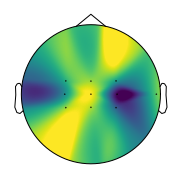

0.2917441622940754 0.6054169786047736


TypeError: savefig() takes 2 positional arguments but 3 were given

<Figure size 432x288 with 0 Axes>

In [52]:
print(mne.__version__)
dig_montage=mne.channels.read_custom_montage("10_10.txt", head_size=0.07, coord_frame='head')
dig_montage.coord_frame = 'head'
raw.set_montage(dig_montage)
# Plot locations with highest lagged coherence rhythmicity score
vmin, vmax = np.min(max_score), np.max(max_score)
im, s =plot_topomap(max_score, raw.info, cmap=cm.viridis,cnorm=(colors.Normalize(vmin=vmin, vmax=vmax)), contours=0, size=3)
print(im.get_array().min(),im.get_array().max())
# im.imsave("test.png")
plt.imsave('image.png', im.get_array())

# Add colorbar
plt.figure(figsize=[2, 4])

sm = cm.ScalarMappable(cmap='viridis', norm=colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array(np.linspace(vmin, vmax))
cbar = plt.colorbar(sm, orientation='vertical', label='Score')
plt.gca().set_visible(False); plt.gcf().subplots_adjust(right=0.5)
plt.show()

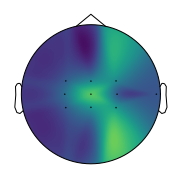

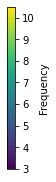

In [35]:
# Plot frequency with most dominant rhythmicity
vmin, vmax = np.min(max_freq)-2, np.max(max_freq)+2
plot_topomap(max_freq, raw.info, cmap=cm.viridis, cnorm=(colors.Normalize(vmin=vmin, vmax=vmax)), contours=0, size=3)

# Add colorbar
plt.figure(figsize=[2, 4])
sm = cm.ScalarMappable(cmap='viridis', norm=colors.Normalize(vmin=vmin, vmax=vmax))
sm.set_array(np.linspace(vmin, vmax))
cbar = plt.colorbar(sm, orientation='vertical', label='Frequency')
plt.gca().set_visible(False); plt.gcf().subplots_adjust(right=0.5)

In [57]:
def spectrogram_algorithm(X, window_size, stride_size, sample_freq, max_freq, num_bins, PCA=0, num_pcs=None,
                          matrix_type=2, small_param=0.0001):
    # convert window and stride sizes from seconds to samples:
    window_size = int(np.floor(sample_freq * window_size))
    stride_size = int(np.floor(sample_freq * stride_size))

    # window data for PSD estimation
    X_window = window_data(X, window_size, stride_size)

    # create spectrograms, optionally with the PCA algorithm:
    spectrograms = spectrogram.create_spectrogram(X_window, sample_freq, max_freq, num_bins, PCA=PCA, num_pcs=num_pcs,
                                                  matrix_type=matrix_type, small_param=small_param)

    return spectrograms


In [72]:
def window_data(X, window_size, stride_size):
    # number of examples:
    num_examples = 1
    # number of channels:
    num_channels = 10
    # number of samples:
    num_samples = len(X)

    # determine number of possible windows:
    num_windows = int(np.floor((num_samples - window_size) / stride_size +1))

    X_window = np.zeros((num_examples, num_windows, num_channels, window_size))
    for i in range(num_windows):
        # start of window index:
        start_index = i * stride_size
        # end of window index (inclusive):
        end_index = start_index + window_size - 1

        X_window[:, i, :, :] = X[:, :, start_index:end_index+1]

    return X_window

In [73]:
def create_spectrogram(X_window, sample_freq, max_freq, num_bins, PCA, num_pcs, matrix_type,
                       small_param):
    # number of examples:
    num_examples = X_window.shape[0]
    # number of windows:
    num_windows = X_window.shape[1]

    # combine first 2 dimensions of X_window:
    #   new size: (num_examples*num_windows, num_channels, window_size)
    X_window = np.reshape(X_window, (-1, X_window.shape[2], X_window.shape[3]))

    # apply PCA algorithm if selected:
    if PCA == 1:
        PSD = feature_algorithms.PCA_on_PSD_algorithm(X_window, sample_freq, max_freq, num_bins, num_pcs=num_pcs,
                                                      matrix_type=matrix_type, small_param=small_param)
    else:
        # construct frequency bins for PSD average calculation:
        bin_width = max_freq / num_bins
        bins = np.zeros((num_bins, 2))
        for i in range(num_bins):
            bins[i, 0] = i * bin_width
            bins[i, 1] = (i + 1) * bin_width

        # calculate average PSD values in frequency bins:
        PSD = feature_algorithms.average_PSD_algorithm(X_window, bins, sample_freq)

    # undo combining of first 2 dimensions of X_window:
    spectrograms = np.reshape(PSD, (num_examples, num_windows, PSD.shape[1], PSD.shape[2]))
    # reorder dimensions of spectrograms so that spectrograms[p, n, t, f] = spectrogram[t, f] of example p, channel n
    spectrograms = np.transpose(spectrograms, axes=(0, 2, 1, 3))

    return spectrograms


In [74]:
# generate spectrogram features without PCA:
PCA = 0
matrix_type = 2
window_size_PSD = 1.0
stride_size_PSD = 0.05
max_freq_spectro = 30
num_bins_spectro = 40
small_param = 0.0001
X_spectro = spectrogram_algorithm(raw, window_size_PSD, stride_size_PSD, sampling_rate, max_freq_spectro,
                                                     num_bins_spectro, PCA=PCA, num_pcs=10,
                                                     matrix_type=matrix_type, small_param=small_param)
# display dimensions of spectrogram images:
print("Size of spectrogram images without PCA: ", end="")
print(X_spectro.shape)
# create and format subplot:
fig, axes = plotter.subplots(nrows=num_plot_examples, ncols=num_plot_channels)
# reshape axes to handle shape error if either dimension = 1
axes = np.reshape(axes, (num_plot_examples, num_plot_channels))
plotter.subplots_adjust(hspace=1)

for i, axis in enumerate(axes.flat):
    # get indices of example and channel:
    example_ind = i // num_plot_channels
    channel_ind = i % num_plot_channels
    axis.imshow(np.transpose(X_spectro[examples[example_ind], channels[channel_ind]]), aspect='equal',
                origin='lower')
    axis.set_title('Spectrogram of Example {0}, {1}'.format(examples[example_ind] + 1,
                                                            channel_names[channels[channel_ind]]))
plotter.tight_layout()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.